<a href="https://colab.research.google.com/github/smarttransit-ai/micro-energy-prediction/blob/main/Diesel%20MY%202014/microDieselMY2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy
import statsmodels
import sklearn
import theano
import tensorflow
import keras
import glob
import os
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from datetime import timedelta
import time
from timeit import default_timer as timer
import statistics
from dask.distributed import Client
from dask import dataframe as dd


In [ ]:
#it is required that you move the raw data from the dropbox location to the Data_Folder
Data_Folder=''

# Data preparation

In [ ]:
#read weather data
weather1 = pd.read_csv(f'{Data_Folder}/darksky_chattanooga.csv', index_col=False)
weather1['period'] = (weather1['time']/300).apply(np.floor)
weather1 = weather1[['humidity','temperature','period']]

In [ ]:
weather2 = pd.read_pickle(r'F:/Research/weather/weatherbit_1_hr_01-01-2017_06-06-2020.pk')
weather2 = weather2.loc[weather2['station_id']=='723240-13882']
weather2['period1']=(weather2['ts']/3600).apply(np.floor)
weather2 = weather2[['rh','temp','period1']]
weather2['temp'] = 32+weather2['temp']*9/5 #convert celsius to fahrenheit

In [ ]:
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='10GB') #note the parameters

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64607 instead
  http_address["port"], self.http_server.port


In [ ]:
vehdata = dd.read_parquet('F:/Research/viriciti/gillelevationfinal',engine="pyarrow")

In [ ]:
veh = vehdata.loc[vehdata['name'] == 'Gillig #147']
veh = veh.compute()

In [ ]:
veh.columns

Index(['unixtimestamp', 'isotime', 'timeuseastern', 'name', 'fuelused',
       'distancedriven', 'acceleratorpedalpercent', 'ambientairtempf',
       'galperhour', 'rpm', 'vehiclespeed', 'altitude', 'latitude',
       'longitude', 'gpsspeed', 'hour', 'minute', 'elevation', 'month',
       'year'],
      dtype='object')

In [ ]:
veh['period']=(veh['unixtimestamp']/300000).apply(np.floor)
veh['period1']=(veh['unixtimestamp']/3600000).apply(np.floor)

In [ ]:
#merge data with weather1
dt = pd.merge(veh,weather1,on=['period'],how='left')
#merge data with weather2
df = pd.merge(dt,weather2,on=['period1'],how='left')

In [ ]:
df['humidity'] = df['humidity'].fillna(df['rh'])
df['temperature'] = df['temperature'].fillna(df['temp'])
df = df.dropna(subset=['vehiclespeed'])
df = df.sort_values(['unixtimestamp'])
print(len(df))
df.columns

5174951


Index(['unixtimestamp', 'isotime', 'timeuseastern', 'name', 'fuelused',
       'distancedriven', 'acceleratorpedalpercent', 'ambientairtempf',
       'galperhour', 'rpm', 'vehiclespeed', 'altitude', 'latitude',
       'longitude', 'gpsspeed', 'hour', 'minute', 'elevation', 'month', 'year',
       'period', 'period1', 'humidity', 'temperature', 'rh', 'temp'],
      dtype='object')

In [ ]:
#process data
df['elevdiff']=df['elevation'].diff() #ft
df['elevdiff']=df['elevdiff']*0.000189394 #convert ft to mile
df['distdiff']=df['distancedriven'].diff()
df['roadGrade']=df['elevdiff']/df['distdiff']
df['roadGrade']=df['roadGrade'].replace(np.inf, 0)
df['roadGrade']=df['roadGrade'].replace(-np.inf, 0)
df['speed'] = df['vehiclespeed']*1.60934 #convert to km/h
#interpolate if raw data is unfilled
FuelRate = df['galperhour']
FuelRate = FuelRate.interpolate()
df['FuelRate'] = FuelRate
Speed = df['speed']
Speed = Speed.interpolate()
df['speed'] = Speed
#calculate acceleration
speedms = df['speed']*1000/3600
df['acceleration']=speedms.diff() #unit: m/s^2
# df = df.drop(df[df.FuelRate == 0].index)
df=df[['speed','acceleration','temperature','humidity','roadGrade','FuelRate',]]
df=df.interpolate(method='linear', limit_direction='forward')
df=df.dropna()
print(len(df))

5174947


In [ ]:
df.head()

,speed,acceleration,temperature,humidity,roadGrade,FuelRate
0,0.0,0.0,77.71,0.64,0.0,1.004
1,0.0,0.0,77.71,0.64,0.0,1.004
2,0.0,0.0,77.71,0.64,0.0,1.004
3,0.0,0.0,77.71,0.64,0.0,1.004
4,0.0,0.0,77.71,0.64,0.0,1.017


In [ ]:
#leave out the final test datasets
final_train, final_test = train_test_split(df,random_state=6,test_size=0.1)
#spilt the remaining dataset
train, test = train_test_split(final_train,random_state=6,test_size=0.3)

In [ ]:
Y_train = train['FuelRate'] #unit: gal/h
X_train = train[['speed','acceleration','temperature','humidity','roadGrade']]
Y_test = test['FuelRate']
X_test = test[['speed','acceleration','temperature','humidity','roadGrade']]

In [ ]:
print(len(train))

3260216


# Model selection based on k-fold cross validation

In [ ]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

In [ ]:
dim = df.shape[1]-1
N_upper = dim*2+1 #the upper limit for the number of neurons in a hidden layer
actlist = ['relu','sigmoid','tanh']

In [ ]:
perform = {}
num_neurons = dim
while num_neurons <= N_upper:
    print('-------------------------------------------------------')
    for act_fun1 in actlist:
        for act_fun2 in actlist:
            #define the k-fold cross validator
            kfold = KFold(n_splits=5, shuffle=True)
            # K-fold Cross Validation model evaluation
            fold_no = 1
            score_per_fold = []
            for train, test in kfold.split(inputs, targets):
                # Define the model architecture
                model = Sequential()
                model.add(Dense(num_neurons, kernel_initializer='normal', input_dim=dim, activation = act_fun1))
                model.add(Dense(num_neurons, kernel_initializer='normal', activation = act_fun2))
                model.add(Dense(1,kernel_initializer='normal', activation ='linear'))
                model.compile(loss='mean_absolute_error', optimizer='adam')   
                # Fit data to model
                history = model.fit(inputs[train], targets[train],batch_size=50000,epochs=30,verbose=0)
                # Generate generalization metrics
                score = model.evaluate(inputs[test], targets[test], verbose=0)        
                score_per_fold.append(score)
                # Increase fold number
                fold_no = fold_no + 1
            mae_mean = np.mean(score_per_fold)
            mae_std = np.std(score_per_fold)
            perform[num_neurons, act_fun1, act_fun2] = mae_mean+mae_std
            print('> neurons=%d, act_fun1=%s, act_fun2=%s: score = %.3f(%.3f)' % (num_neurons, act_fun1, act_fun2, mae_mean, mae_std))
    num_neurons = num_neurons + 1

-------------------------------------------------------
> neurons=5, act_fun1=relu, act_fun2=relu: score = 0.988(0.017)
> neurons=5, act_fun1=relu, act_fun2=sigmoid: score = 1.085(0.009)
> neurons=5, act_fun1=relu, act_fun2=tanh: score = 1.028(0.013)
> neurons=5, act_fun1=sigmoid, act_fun2=relu: score = 1.117(0.217)
> neurons=5, act_fun1=sigmoid, act_fun2=sigmoid: score = 1.119(0.026)
> neurons=5, act_fun1=sigmoid, act_fun2=tanh: score = 1.052(0.006)
> neurons=5, act_fun1=tanh, act_fun2=relu: score = 0.985(0.015)
> neurons=5, act_fun1=tanh, act_fun2=sigmoid: score = 1.058(0.007)
> neurons=5, act_fun1=tanh, act_fun2=tanh: score = 1.046(0.015)
-------------------------------------------------------
> neurons=6, act_fun1=relu, act_fun2=relu: score = 0.973(0.018)
> neurons=6, act_fun1=relu, act_fun2=sigmoid: score = 1.068(0.038)
> neurons=6, act_fun1=relu, act_fun2=tanh: score = 0.997(0.015)
> neurons=6, act_fun1=sigmoid, act_fun2=relu: score = 0.996(0.014)
> neurons=6, act_fun1=sigmoid, a

In [ ]:
#find the parameters with the lowest score (mae_mean+mae_std)
ans =[min(perform, key=perform.get)]
print(ans)

[(11, 'tanh', 'relu')]


# Final model

In [ ]:
#build the final ann model
Y_train_final = final_train['FuelRate'] #unit: gal/h
X_train_final = final_train[['speed','acceleration','temperature','humidity','roadGrade']]
final_model = Sequential()
final_model.add(Dense(ans[0][0],kernel_initializer='normal', input_dim=dim, activation =ans[0][1]))
final_model.add(Dense(ans[0][0], kernel_initializer='normal', activation =ans[0][2]))
final_model.add(Dense(1,kernel_initializer='normal', activation ='linear'))
final_model.compile(loss='mean_absolute_error', optimizer='adam')

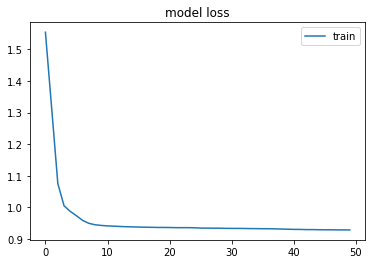

MAE is 0.9268234587855136
final loss is 0.9287329640495235


In [ ]:
#fit model
history = final_model.fit(X_train_final, Y_train_final, epochs=50, 
                    batch_size=20000, verbose = 0)
#performance
plt.plot(history.history['loss'], label='train')
plt.title('model loss')
plt.legend()
plt.show()

scores = final_model.evaluate(X_test, Y_test, verbose=0)
print("MAE is",scores)
print("final loss is",history.history['loss'][-1])

In [ ]:
final_model.save('F:/Research/EnergyEstimation/model/diesel_MY2014.model')

# Prediction-test

In [ ]:
model = keras.models.load_model('F:/Research/EnergyEstimation/model/diesel_MY2014.model')

In [ ]:
#prdiction 
Y_test_final = final_test['FuelRate']
X_test_final = final_test[['speed','acceleration','temperature','humidity','roadGrade']]
pred = model.predict(X_test_final)

In [ ]:
true = Y_test_final.to_numpy()

In [ ]:
#error
print('MAE=',mean_absolute_error(Y_test_final, pred))
print('MSE=',mean_squared_error(Y_test_final, pred))


MAE= 0.928624746229672
MSE= 3.015283175135569
